In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.01 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36614 
    Total predicted counts          : 36992.54
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 35.8 s, sys: 323 ms, total: 36.1 s
Wall time: 37.1 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37031 
    Total predicted counts          : 37041.14
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36776 
    Total predicted counts          : 36975.54
    Total off counts                : 101332.00

    Total background counts         : 2


SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 36968 
    Total predicted counts          : 36985.74
    Total off counts                : 101383.00

    Total background counts         : 20276.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_13 

    Total counts                    : 37108 
    Total predicted counts          : 37015.94
    Total off counts                : 101534.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 36887 
    Total predicted counts          : 37119.14
    Total off counts                : 102050.00

    Total background counts         : 20410.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 37120 
    Total predicted counts          : 36994.34
    Total off counts                : 101426.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_43 

    Total counts                    : 36672 
    Total predicted counts          : 37124.14
    Total off counts                : 102075.00

    Total background counts         : 20415.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_44 

    Total counts                    : 37161 
    Total predicted counts          : 37082.94
    Total off counts                : 101869.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_57 

    Total counts                    : 36815 
    Total predicted counts          : 36977.34
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_58 

    Total counts                    : 36912 
    Total predicted counts          : 37033.34
    Total off counts                : 101621.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_69 

    Total counts                    : 36809 
    Total predicted counts          : 36917.54
    Total off counts                : 101042.00

    Total background counts         : 20208.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_70 

    Total counts                    : 37029 
    Total predicted counts          : 37014.94
    Total off counts                : 101529.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_85 

    Total counts                    : 36992 
    Total predicted counts          : 36945.94
    Total off counts                : 101184.00

    Total background counts         : 20236.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 36856 
    Total predicted counts          : 36994.74
    Total off counts                : 101428.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_100 

    Total counts                    : 37119 
    Total predicted counts          : 37004.94
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_101 

    Total counts                    : 37007 
    Total predicted counts          : 37060.54
    Total off counts                : 101757.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_114 

    Total counts                    : 37338 
    Total predicted counts          : 36915.94
    Total off counts                : 101034.00

    Total background counts         : 20206.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 37201 
    Total predicted counts          : 36907.74
    Total off counts                : 100993.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 36970 
    Total predicted counts          : 37009.94
    Total off counts                : 101504.00

    Total background counts         : 20300.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 37199 
    Total predicted counts          : 37066.74
    Total off counts                : 101788.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 36913 
    Total predicted counts          : 36970.14
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 37201 
    Total predicted counts          : 37016.34
    Total off counts                : 101536.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 36951 
    Total predicted counts          : 36975.34
    Total off counts                : 101331.00

    Total background counts         : 20266.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_165 

    Total counts                    : 37323 
    Total predicted counts          : 37100.74
    Total off counts                : 101958.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_183 

    Total counts                    : 37051 
    Total predicted counts          : 36990.94
    Total off counts                : 101409.00

    Total background counts         : 20281.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_184 

    Total counts                    : 37066 
    Total predicted counts          : 37112.34
    Total off counts                : 102016.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_201 

    Total counts                    : 36907 
    Total predicted counts          : 36927.14
    Total off counts                : 101090.00

    Total background counts         : 20218.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 37125 
    Total predicted counts          : 37038.94
    Total off counts                : 101649.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_217 

    Total counts                    : 37038 
    Total predicted counts          : 37013.74
    Total off counts                : 101523.00

    Total background counts         : 20304.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_218 

    Total counts                    : 37125 
    Total predicted counts          : 36949.74
    Total off counts                : 101203.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_235 

    Total counts                    : 36850 
    Total predicted counts          : 36904.54
    Total off counts                : 100977.00

    Total background counts         : 20195.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_236 

    Total counts                    : 36863 
    Total predicted counts          : 36983.34
    Total off counts                : 101371.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_251 

    Total counts                    : 37169 
    Total predicted counts          : 37038.54
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 36884 
    Total predicted counts          : 37077.74
    Total off counts                : 101843.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_269 

    Total counts                    : 36973 
    Total predicted counts          : 37089.14
    Total off counts                : 101900.00

    Total background counts         : 20380.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_270 

    Total counts                    : 37042 
    Total predicted counts          : 36936.94
    Total off counts                : 101139.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 36839 
    Total predicted counts          : 37065.14
    Total off counts                : 101780.00

    Total background counts         : 20356.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 37052 
    Total predicted counts          : 37057.94
    Total off counts                : 101744.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_301 

    Total counts                    : 37165 
    Total predicted counts          : 37132.94
    Total off counts                : 102119.00

    Total background counts         : 20423.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 36849 
    Total predicted counts          : 36941.34
    Total off counts                : 101161.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_316 

    Total counts                    : 37138 
    Total predicted counts          : 37083.54
    Total off counts                : 101872.00

    Total background counts         : 20374.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_317 

    Total counts                    : 37039 
    Total predicted counts          : 37106.74
    Total off counts                : 101988.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_332 

    Total counts                    : 37022 
    Total predicted counts          : 37050.14
    Total off counts                : 101705.00

    Total background counts         : 20341.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_333 

    Total counts                    : 36383 
    Total predicted counts          : 37050.14
    Total off counts                : 101705.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_348 

    Total counts                    : 36703 
    Total predicted counts          : 37037.34
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_349 

    Total counts                    : 37154 
    Total predicted counts          : 37020.74
    Total off counts                : 101558.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_363 

    Total counts                    : 36871 
    Total predicted counts          : 37016.54
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_364 

    Total counts                    : 37085 
    Total predicted counts          : 37060.54
    Total off counts                : 101757.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 37084 
    Total predicted counts          : 37086.94
    Total off counts                : 101889.00

    Total background counts         : 20377.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 37078 
    Total predicted counts          : 36996.34
    Total off counts                : 101436.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_394 

    Total counts                    : 36750 
    Total predicted counts          : 37076.34
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 36900 
    Total predicted counts          : 37012.54
    Total off counts                : 101517.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 37190 
    Total predicted counts          : 37040.94
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 36974 
    Total predicted counts          : 36990.74
    Total off counts                : 101408.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_424 

    Total counts                    : 37048 
    Total predicted counts          : 36940.54
    Total off counts                : 101157.00

    Total background counts         : 20231.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_425 

    Total counts                    : 37076 
    Total predicted counts          : 37132.14
    Total off counts                : 102115.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_439 

    Total counts                    : 36917 
    Total predicted counts          : 37011.34
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 37115 
    Total predicted counts          : 36915.14
    Total off counts                : 101030.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_453 

    Total counts                    : 37141 
    Total predicted counts          : 37152.54
    Total off counts                : 102217.00

    Total background counts         : 20443.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_454 

    Total counts                    : 37215 
    Total predicted counts          : 36980.94
    Total off counts                : 101359.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_468 

    Total counts                    : 36885 
    Total predicted counts          : 37038.14
    Total off counts                : 101645.00

    Total background counts         : 20329.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_469 

    Total counts                    : 36946 
    Total predicted counts          : 37014.94
    Total off counts                : 101529.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_484 

    Total counts                    : 37388 
    Total predicted counts          : 37032.34
    Total off counts                : 101616.00

    Total background counts         : 20323.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_485 

    Total counts                    : 37321 
    Total predicted counts          : 37077.94
    Total off counts                : 101844.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_500 

    Total counts                    : 37259 
    Total predicted counts          : 36913.14
    Total off counts                : 101020.00

    Total background counts         : 20204.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_501 

    Total counts                    : 37045 
    Total predicted counts          : 36968.74
    Total off counts                : 101298.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_516 

    Total counts                    : 36985 
    Total predicted counts          : 36978.94
    Total off counts                : 101349.00

    Total background counts         : 20269.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_517 

    Total counts                    : 36902 
    Total predicted counts          : 37075.34
    Total off counts                : 101831.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_533 

    Total counts                    : 36774 
    Total predicted counts          : 37041.34
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_534 

    Total counts                    : 37420 
    Total predicted counts          : 37032.54
    Total off counts                : 101617.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_548 

    Total counts                    : 36990 
    Total predicted counts          : 37038.34
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_549 

    Total counts                    : 36926 
    Total predicted counts          : 36941.14
    Total off counts                : 101160.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_561 

    Total counts                    : 37126 
    Total predicted counts          : 37058.14
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_562 

    Total counts                    : 36823 
    Total predicted counts          : 37026.94
    Total off counts                : 101589.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_577 

    Total counts                    : 36963 
    Total predicted counts          : 36965.94
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_578 

    Total counts                    : 37297 
    Total predicted counts          : 37091.54
    Total off counts                : 101912.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_592 

    Total counts                    : 36979 
    Total predicted counts          : 37037.34
    Total off counts                : 101641.00

    Total background counts         : 20328.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_593 

    Total counts                    : 36785 
    Total predicted counts          : 36932.94
    Total off counts                : 101119.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 36936 
    Total predicted counts          : 36969.74
    Total off counts                : 101303.00

    Total background counts         : 20260.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_607 

    Total counts                    : 37121 
    Total predicted counts          : 37008.34
    Total off counts                : 101496.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 37053 
    Total predicted counts          : 37080.54
    Total off counts                : 101857.00

    Total background counts         : 20371.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_621 

    Total counts                    : 36850 
    Total predicted counts          : 36968.94
    Total off counts                : 101299.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 36992 
    Total predicted counts          : 37079.74
    Total off counts                : 101853.00

    Total background counts         : 20370.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_635 

    Total counts                    : 37186 
    Total predicted counts          : 37005.54
    Total off counts                : 101482.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_649 

    Total counts                    : 37029 
    Total predicted counts          : 37098.74
    Total off counts                : 101948.00

    Total background counts         : 20389.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_650 

    Total counts                    : 36964 
    Total predicted counts          : 36915.14
    Total off counts                : 101030.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_663 

    Total counts                    : 36896 
    Total predicted counts          : 36992.34
    Total off counts                : 101416.00

    Total background counts         : 20283.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_664 

    Total counts                    : 36771 
    Total predicted counts          : 37054.54
    Total off counts                : 101727.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_678 

    Total counts                    : 37209 
    Total predicted counts          : 36891.94
    Total off counts                : 100914.00

    Total background counts         : 20182.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_679 

    Total counts                    : 36930 
    Total predicted counts          : 37050.54
    Total off counts                : 101707.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 37116 
    Total predicted counts          : 37029.74
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_694 

    Total counts                    : 37234 
    Total predicted counts          : 36972.94
    Total off counts                : 101319.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_706 

    Total counts                    : 37014 
    Total predicted counts          : 37151.94
    Total off counts                : 102214.00

    Total background counts         : 20442.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_707 

    Total counts                    : 36854 
    Total predicted counts          : 36965.94
    Total off counts                : 101284.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_720 

    Total counts                    : 37078 
    Total predicted counts          : 36943.94
    Total off counts                : 101174.00

    Total background counts         : 20234.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_721 

    Total counts                    : 36827 
    Total predicted counts          : 37086.14
    Total off counts                : 101885.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_734 

    Total counts                    : 37122 
    Total predicted counts          : 36959.54
    Total off counts                : 101252.00

    Total background counts         : 20250.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_735 

    Total counts                    : 37166 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 36989 
    Total predicted counts          : 36994.14
    Total off counts                : 101425.00

    Total background counts         : 20285.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 37239 
    Total predicted counts          : 36962.74
    Total off counts                : 101268.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_763 

    Total counts                    : 37015 
    Total predicted counts          : 37093.74
    Total off counts                : 101923.00

    Total background counts         : 20384.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_764 

    Total counts                    : 37374 
    Total predicted counts          : 36953.74
    Total off counts                : 101223.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_775 

    Total counts                    : 36780 
    Total predicted counts          : 37007.94
    Total off counts                : 101494.00

    Total background counts         : 20298.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_776 

    Total counts                    : 37500 
    Total predicted counts          : 37126.74
    Total off counts                : 102088.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_789 

    Total counts                    : 36901 
    Total predicted counts          : 37034.14
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_790 

    Total counts                    : 37169 
    Total predicted counts          : 36944.34
    Total off counts                : 101176.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 36874 
    Total predicted counts          : 37040.94
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_806 

    Total counts                    : 37408 
    Total predicted counts          : 37054.54
    Total off counts                : 101727.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_818 

    Total counts                    : 37055 
    Total predicted counts          : 36929.34
    Total off counts                : 101101.00

    Total background counts         : 20220.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_819 

    Total counts                    : 37005 
    Total predicted counts          : 36978.54
    Total off counts                : 101347.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 37144 
    Total predicted counts          : 37078.74
    Total off counts                : 101848.00

    Total background counts         : 20369.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 37096 
    Total predicted counts          : 36931.14
    Total off counts                : 101110.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_845 

    Total counts                    : 37044 
    Total predicted counts          : 36999.74
    Total off counts                : 101453.00

    Total background counts         : 20290.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_846 

    Total counts                    : 36897 
    Total predicted counts          : 36945.74
    Total off counts                : 101183.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_860 

    Total counts                    : 37321 
    Total predicted counts          : 37164.14
    Total off counts                : 102275.00

    Total background counts         : 20455.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 37080 
    Total predicted counts          : 36900.94
    Total off counts                : 100959.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_874 

    Total counts                    : 37182 
    Total predicted counts          : 37072.14
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_875 

    Total counts                    : 37021 
    Total predicted counts          : 37088.74
    Total off counts                : 101898.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_888 

    Total counts                    : 36908 
    Total predicted counts          : 36985.34
    Total off counts                : 101381.00

    Total background counts         : 20276.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 22.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_889 

    Total counts                    : 37294 
    Total predicted counts          : 36972.14
    Total off counts                : 101315.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_903 

    Total counts                    : 37079 
    Total predicted counts          : 37014.54
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_904 

    Total counts                    : 36792 
    Total predicted counts          : 36962.94
    Total off counts                : 101269.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_918 

    Total counts                    : 37155 
    Total predicted counts          : 36917.14
    Total off counts                : 101040.00

    Total background counts         : 20208.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_919 

    Total counts                    : 36799 
    Total predicted counts          : 37042.94
    Total off counts                : 101669.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_933 

    Total counts                    : 37061 
    Total predicted counts          : 36938.34
    Total off counts                : 101146.00

    Total background counts         : 20229.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_934 

    Total counts                    : 37035 
    Total predicted counts          : 37120.54
    Total off counts                : 102057.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 36870 
    Total predicted counts          : 36988.34
    Total off counts                : 101396.00

    Total background counts         : 20279.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_949 

    Total counts                    : 36763 
    Total predicted counts          : 37006.14
    Total off counts                : 101485.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_961 

    Total counts                    : 37112 
    Total predicted counts          : 36981.34
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_962 

    Total counts                    : 37020 
    Total predicted counts          : 37179.34
    Total off counts                : 102351.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_976 

    Total counts                    : 37274 
    Total predicted counts          : 37003.74
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_977 

    Total counts                    : 36604 
    Total predicted counts          : 37014.54
    Total off counts                : 101527.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_992 

    Total counts                    : 37008 
    Total predicted counts          : 36953.54
    Total off counts                : 101222.00

    Total background counts         : 20244.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_993 

    Total counts                    : 36693 
    Total predicted counts          : 36934.94
    Total off counts                : 101129.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1012 

    Total counts                    : 37200 
    Total predicted counts          : 36995.94
    Total off counts                : 101434.00

    Total background counts         : 20286.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1013 

    Total counts                    : 36658 
    Total predicted counts          : 36979.74
    Total off counts                : 101353.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1031 

    Total counts                    : 36920 
    Total predicted counts          : 37053.14
    Total off counts                : 101720.00

    Total background counts         : 20344.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1032 

    Total counts                    : 36990 
    Total predicted counts          : 37078.74
    Total off counts                : 101848.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1047 

    Total counts                    : 37071 
    Total predicted counts          : 37103.94
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1048 

    Total counts                    : 36722 
    Total predicted counts          : 36928.34
    Total off counts                : 101096.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1067 

    Total counts                    : 36872 
    Total predicted counts          : 37023.14
    Total off counts                : 101570.00

    Total background counts         : 20314.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1068 

    Total counts                    : 37000 
    Total predicted counts          : 37028.14
    Total off counts                : 101595.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1081 

    Total counts                    : 37369 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1082 

    Total counts                    : 37259 
    Total predicted counts          : 36886.74
    Total off counts                : 100888.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1099 

    Total counts                    : 37241 
    Total predicted counts          : 37058.74
    Total off counts                : 101748.00

    Total background counts         : 20349.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1100 

    Total counts                    : 36929 
    Total predicted counts          : 37006.14
    Total off counts                : 101485.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1114 

    Total counts                    : 37198 
    Total predicted counts          : 36950.94
    Total off counts                : 101209.00

    Total background counts         : 20241.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1115 

    Total counts                    : 36826 
    Total predicted counts          : 37033.74
    Total off counts                : 101623.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1131 

    Total counts                    : 36668 
    Total predicted counts          : 37105.34
    Total off counts                : 101981.00

    Total background counts         : 20396.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1132 

    Total counts                    : 37233 
    Total predicted counts          : 37087.54
    Total off counts                : 101892.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1146 

    Total counts                    : 37103 
    Total predicted counts          : 37072.94
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1147 

    Total counts                    : 37187 
    Total predicted counts          : 37129.54
    Total off counts                : 102102.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1165 

    Total counts                    : 37168 
    Total predicted counts          : 36970.34
    Total off counts                : 101306.00

    Total background counts         : 20261.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1166 

    Total counts                    : 36981 
    Total predicted counts          : 36980.34
    Total off counts                : 101356.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1181 

    Total counts                    : 36959 
    Total predicted counts          : 36936.34
    Total off counts                : 101136.00

    Total background counts         : 20227.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1182 

    Total counts                    : 37117 
    Total predicted counts          : 37048.14
    Total off counts                : 101695.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1199 

    Total counts                    : 37402 
    Total predicted counts          : 37087.94
    Total off counts                : 101894.00

    Total background counts         : 20378.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1200 

    Total counts                    : 36982 
    Total predicted counts          : 37022.14
    Total off counts                : 101565.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1219 

    Total counts                    : 37333 
    Total predicted counts          : 37065.94
    Total off counts                : 101784.00

    Total background counts         : 20356.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1220 

    Total counts                    : 37124 
    Total predicted counts          : 37014.54
    Total off counts                : 101527.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 36998 
    Total predicted counts          : 37085.94
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1237 

    Total counts                    : 37427 
    Total predicted counts          : 37062.54
    Total off counts                : 101767.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1254 

    Total counts                    : 37167 
    Total predicted counts          : 36981.94
    Total off counts                : 101364.00

    Total background counts         : 20272.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1255 

    Total counts                    : 36698 
    Total predicted counts          : 37046.34
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1274 

    Total counts                    : 36985 
    Total predicted counts          : 37058.54
    Total off counts                : 101747.00

    Total background counts         : 20349.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1275 

    Total counts                    : 36910 
    Total predicted counts          : 36987.14
    Total off counts                : 101390.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1296 

    Total counts                    : 36820 
    Total predicted counts          : 36978.94
    Total off counts                : 101349.00

    Total background counts         : 20269.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1297 

    Total counts                    : 36878 
    Total predicted counts          : 36964.54
    Total off counts                : 101277.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1318 

    Total counts                    : 36869 
    Total predicted counts          : 37040.94
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1319 

    Total counts                    : 37342 
    Total predicted counts          : 37059.34
    Total off counts                : 101751.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1336 

    Total counts                    : 37084 
    Total predicted counts          : 37042.34
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1337 

    Total counts                    : 36848 
    Total predicted counts          : 36928.14
    Total off counts                : 101095.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1351 

    Total counts                    : 36713 
    Total predicted counts          : 37034.74
    Total off counts                : 101628.00

    Total background counts         : 20325.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1352 

    Total counts                    : 36854 
    Total predicted counts          : 37047.14
    Total off counts                : 101690.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1367 

    Total counts                    : 37291 
    Total predicted counts          : 37026.34
    Total off counts                : 101586.00

    Total background counts         : 20317.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1368 

    Total counts                    : 36798 
    Total predicted counts          : 36995.54
    Total off counts                : 101432.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1382 

    Total counts                    : 36877 
    Total predicted counts          : 37018.74
    Total off counts                : 101548.00

    Total background counts         : 20309.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1383 

    Total counts                    : 37535 
    Total predicted counts          : 36964.94
    Total off counts                : 101279.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1397 

    Total counts                    : 37120 
    Total predicted counts          : 36949.94
    Total off counts                : 101204.00

    Total background counts         : 20240.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1398 

    Total counts                    : 37189 
    Total predicted counts          : 37018.94
    Total off counts                : 101549.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1413 

    Total counts                    : 36748 
    Total predicted counts          : 37037.94
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1414 

    Total counts                    : 36817 
    Total predicted counts          : 37072.74
    Total off counts                : 101818.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1429 

    Total counts                    : 36977 
    Total predicted counts          : 37020.94
    Total off counts                : 101559.00

    Total background counts         : 20311.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1430 

    Total counts                    : 36491 
    Total predicted counts          : 36862.74
    Total off counts                : 100768.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 36954 
    Total predicted counts          : 36871.14
    Total off counts                : 100810.00

    Total background counts         : 20162.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1445 

    Total counts                    : 37136 
    Total predicted counts          : 37064.54
    Total off counts                : 101777.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1459 

    Total counts                    : 37021 
    Total predicted counts          : 37044.74
    Total off counts                : 101678.00

    Total background counts         : 20335.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1460 

    Total counts                    : 37211 
    Total predicted counts          : 37119.74
    Total off counts                : 102053.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1473 

    Total counts                    : 37215 
    Total predicted counts          : 37082.74
    Total off counts                : 101868.00

    Total background counts         : 20373.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1474 

    Total counts                    : 37111 
    Total predicted counts          : 37042.34
    Total off counts                : 101666.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1494 

    Total counts                    : 37272 
    Total predicted counts          : 37079.14
    Total off counts                : 101850.00

    Total background counts         : 20370.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1495 

    Total counts                    : 36842 
    Total predicted counts          : 37044.34
    Total off counts                : 101676.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1514 

    Total counts                    : 36841 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1515 

    Total counts                    : 36966 
    Total predicted counts          : 36955.54
    Total off counts                : 101232.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1535 

    Total counts                    : 37043 
    Total predicted counts          : 37083.74
    Total off counts                : 101873.00

    Total background counts         : 20374.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1536 

    Total counts                    : 37007 
    Total predicted counts          : 36944.94
    Total off counts                : 101179.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1557 

    Total counts                    : 36842 
    Total predicted counts          : 37068.74
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 36971 
    Total predicted counts          : 36966.74
    Total off counts                : 101288.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1577 

    Total counts                    : 36746 
    Total predicted counts          : 36989.74
    Total off counts                : 101403.00

    Total background counts         : 20280.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1578 

    Total counts                    : 36952 
    Total predicted counts          : 37118.74
    Total off counts                : 102048.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1595 

    Total counts                    : 36763 
    Total predicted counts          : 36951.34
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1596 

    Total counts                    : 37515 
    Total predicted counts          : 37034.94
    Total off counts                : 101629.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1615 

    Total counts                    : 36995 
    Total predicted counts          : 37132.34
    Total off counts                : 102116.00

    Total background counts         : 20423.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1616 

    Total counts                    : 36857 
    Total predicted counts          : 36981.54
    Total off counts                : 101362.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1633 

    Total counts                    : 36618 
    Total predicted counts          : 37099.14
    Total off counts                : 101950.00

    Total background counts         : 20390.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1634 

    Total counts                    : 37266 
    Total predicted counts          : 36997.94
    Total off counts                : 101444.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1649 

    Total counts                    : 36910 
    Total predicted counts          : 36984.14
    Total off counts                : 101375.00

    Total background counts         : 20275.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1650 

    Total counts                    : 37103 
    Total predicted counts          : 36956.74
    Total off counts                : 101238.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1665 

    Total counts                    : 36759 
    Total predicted counts          : 37063.94
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1666 

    Total counts                    : 37136 
    Total predicted counts          : 36955.34
    Total off counts                : 101231.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1682 

    Total counts                    : 36553 
    Total predicted counts          : 37053.34
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1683 

    Total counts                    : 37007 
    Total predicted counts          : 37038.74
    Total off counts                : 101648.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1700 

    Total counts                    : 37097 
    Total predicted counts          : 37070.14
    Total off counts                : 101805.00

    Total background counts         : 20361.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1701 

    Total counts                    : 36973 
    Total predicted counts          : 36974.74
    Total off counts                : 101328.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1719 

    Total counts                    : 36953 
    Total predicted counts          : 37003.54
    Total off counts                : 101472.00

    Total background counts         : 20294.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1720 

    Total counts                    : 37008 
    Total predicted counts          : 37022.14
    Total off counts                : 101565.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1736 

    Total counts                    : 36505 
    Total predicted counts          : 37136.14
    Total off counts                : 102135.00

    Total background counts         : 20427.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1737 

    Total counts                    : 36879 
    Total predicted counts          : 37015.94
    Total off counts                : 101534.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1754 

    Total counts                    : 36667 
    Total predicted counts          : 37042.54
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1755 

    Total counts                    : 36867 
    Total predicted counts          : 37078.34
    Total off counts                : 101846.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1772 

    Total counts                    : 37261 
    Total predicted counts          : 36971.94
    Total off counts                : 101314.00

    Total background counts         : 20262.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1773 

    Total counts                    : 37123 
    Total predicted counts          : 37030.14
    Total off counts                : 101605.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1790 

    Total counts                    : 36846 
    Total predicted counts          : 37061.94
    Total off counts                : 101764.00

    Total background counts         : 20352.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1791 

    Total counts                    : 36930 
    Total predicted counts          : 36903.34
    Total off counts                : 100971.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1809 

    Total counts                    : 36993 
    Total predicted counts          : 36951.14
    Total off counts                : 101210.00

    Total background counts         : 20242.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1810 

    Total counts                    : 37322 
    Total predicted counts          : 36972.54
    Total off counts                : 101317.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1826 

    Total counts                    : 36794 
    Total predicted counts          : 37128.14
    Total off counts                : 102095.00

    Total background counts         : 20419.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1827 

    Total counts                    : 37423 
    Total predicted counts          : 36941.54
    Total off counts                : 101162.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1842 

    Total counts                    : 36929 
    Total predicted counts          : 36935.74
    Total off counts                : 101133.00

    Total background counts         : 20226.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1843 

    Total counts                    : 36780 
    Total predicted counts          : 37047.94
    Total off counts                : 101694.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1854 

    Total counts                    : 37233 
    Total predicted counts          : 36982.14
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1855 

    Total counts                    : 36655 
    Total predicted counts          : 36934.34
    Total off counts                : 101126.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1865 

    Total counts                    : 36557 
    Total predicted counts          : 37067.34
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1866 

    Total counts                    : 36792 
    Total predicted counts          : 37005.74
    Total off counts                : 101483.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1877 

    Total counts                    : 36828 
    Total predicted counts          : 37068.74
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1878 

    Total counts                    : 37001 
    Total predicted counts          : 36933.34
    Total off counts                : 101121.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1890 

    Total counts                    : 36900 
    Total predicted counts          : 37010.34
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1891 

    Total counts                    : 36971 
    Total predicted counts          : 37024.94
    Total off counts                : 101579.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1902 

    Total counts                    : 37072 
    Total predicted counts          : 37077.54
    Total off counts                : 101842.00

    Total background counts         : 20368.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1903 

    Total counts                    : 36994 
    Total predicted counts          : 37008.94
    Total off counts                : 101499.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1914 

    Total counts                    : 37118 
    Total predicted counts          : 36944.54
    Total off counts                : 101177.00

    Total background counts         : 20235.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1915 

    Total counts                    : 37267 
    Total predicted counts          : 37002.94
    Total off counts                : 101469.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1927 

    Total counts                    : 36801 
    Total predicted counts          : 37085.74
    Total off counts                : 101883.00

    Total background counts         : 20376.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1928 

    Total counts                    : 37259 
    Total predicted counts          : 36995.54
    Total off counts                : 101432.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1941 

    Total counts                    : 37003 
    Total predicted counts          : 36929.74
    Total off counts                : 101103.00

    Total background counts         : 20220.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1942 

    Total counts                    : 37462 
    Total predicted counts          : 36886.34
    Total off counts                : 100886.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1956 

    Total counts                    : 37076 
    Total predicted counts          : 36994.34
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1957 

    Total counts                    : 36869 
    Total predicted counts          : 37009.14
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1969 

    Total counts                    : 36848 
    Total predicted counts          : 37014.14
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1970 

    Total counts                    : 37003 
    Total predicted counts          : 36972.74
    Total off counts                : 101318.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1983 

    Total counts                    : 37037 
    Total predicted counts          : 37008.54
    Total off counts                : 101497.00

    Total background counts         : 20299.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1984 

    Total counts                    : 36391 
    Total predicted counts          : 37065.14
    Total off counts                : 101780.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1996 

    Total counts                    : 36993 
    Total predicted counts          : 37004.14
    Total off counts                : 101475.00

    Total background counts         : 20295.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1997 

    Total counts                    : 37133 
    Total predicted counts          : 36969.34
    Total off counts                : 101301.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2011 

    Total counts                    : 37023 
    Total predicted counts          : 37003.14
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2012 

    Total counts                    : 36934 
    Total predicted counts          : 37072.34
    Total off counts                : 101816.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2023 

    Total counts                    : 36849 
    Total predicted counts          : 37102.34
    Total off counts                : 101966.00

    Total background counts         : 20393.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2024 

    Total counts                    : 37053 
    Total predicted counts          : 37116.54
    Total off counts                : 102037.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2036 

    Total counts                    : 37049 
    Total predicted counts          : 36953.14
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2037 

    Total counts                    : 36917 
    Total predicted counts          : 37066.74
    Total off counts                : 101788.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2047 

    Total counts                    : 37083 
    Total predicted counts          : 37044.74
    Total off counts                : 101678.00

    Total background counts         : 20335.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2048 

    Total counts                    : 36790 
    Total predicted counts          : 36898.14
    Total off counts                : 100945.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2059 

    Total counts                    : 37281 
    Total predicted counts          : 36883.34
    Total off counts                : 100871.00

    Total background counts         : 20174.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2060 

    Total counts                    : 37189 
    Total predicted counts          : 37060.34
    Total off counts                : 101756.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2071 

    Total counts                    : 37245 
    Total predicted counts          : 37021.54
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2072 

    Total counts                    : 36767 
    Total predicted counts          : 37086.74
    Total off counts                : 101888.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2082 

    Total counts                    : 36995 
    Total predicted counts          : 36964.34
    Total off counts                : 101276.00

    Total background counts         : 20255.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2083 

    Total counts                    : 37395 
    Total predicted counts          : 37047.74
    Total off counts                : 101693.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2095 

    Total counts                    : 36765 
    Total predicted counts          : 37097.14
    Total off counts                : 101940.00

    Total background counts         : 20388.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2096 

    Total counts                    : 36968 
    Total predicted counts          : 37045.54
    Total off counts                : 101682.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2108 

    Total counts                    : 37223 
    Total predicted counts          : 36926.74
    Total off counts                : 101088.00

    Total background counts         : 20217.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2109 

    Total counts                    : 36982 
    Total predicted counts          : 36936.54
    Total off counts                : 101137.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2123 

    Total counts                    : 37113 
    Total predicted counts          : 37035.14
    Total off counts                : 101630.00

    Total background counts         : 20326.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2124 

    Total counts                    : 37322 
    Total predicted counts          : 36999.94
    Total off counts                : 101454.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2136 

    Total counts                    : 36961 
    Total predicted counts          : 37019.74
    Total off counts                : 101553.00

    Total background counts         : 20310.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2137 

    Total counts                    : 37304 
    Total predicted counts          : 37123.34
    Total off counts                : 102071.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2150 

    Total counts                    : 37179 
    Total predicted counts          : 37016.34
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2151 

    Total counts                    : 37003 
    Total predicted counts          : 37088.54
    Total off counts                : 101897.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2163 

    Total counts                    : 36927 
    Total predicted counts          : 36976.14
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2164 

    Total counts                    : 37134 
    Total predicted counts          : 37051.34
    Total off counts                : 101711.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2176 

    Total counts                    : 36854 
    Total predicted counts          : 37041.74
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2177 

    Total counts                    : 36743 
    Total predicted counts          : 37004.54
    Total off counts                : 101477.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2190 

    Total counts                    : 37322 
    Total predicted counts          : 37074.34
    Total off counts                : 101826.00

    Total background counts         : 20365.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2191 

    Total counts                    : 37261 
    Total predicted counts          : 37059.74
    Total off counts                : 101753.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2206 

    Total counts                    : 37184 
    Total predicted counts          : 37025.74
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2207 

    Total counts                    : 36805 
    Total predicted counts          : 36977.34
    Total off counts                : 101341.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2220 

    Total counts                    : 36976 
    Total predicted counts          : 37074.74
    Total off counts                : 101828.00

    Total background counts         : 20365.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2221 

    Total counts                    : 36985 
    Total predicted counts          : 36954.14
    Total off counts                : 101225.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2235 

    Total counts                    : 37013 
    Total predicted counts          : 36986.34
    Total off counts                : 101386.00

    Total background counts         : 20277.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2236 

    Total counts                    : 37203 
    Total predicted counts          : 37036.94
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2247 

    Total counts                    : 37356 
    Total predicted counts          : 36957.34
    Total off counts                : 101241.00

    Total background counts         : 20248.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2248 

    Total counts                    : 37301 
    Total predicted counts          : 36968.34
    Total off counts                : 101296.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2258 

    Total counts                    : 36883 
    Total predicted counts          : 36896.54
    Total off counts                : 100937.00

    Total background counts         : 20187.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2259 

    Total counts                    : 37111 
    Total predicted counts          : 37079.74
    Total off counts                : 101853.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2273 

    Total counts                    : 36939 
    Total predicted counts          : 37053.94
    Total off counts                : 101724.00

    Total background counts         : 20344.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2274 

    Total counts                    : 37239 
    Total predicted counts          : 36988.94
    Total off counts                : 101399.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2296 

    Total counts                    : 36944 
    Total predicted counts          : 36977.94
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2297 

    Total counts                    : 37373 
    Total predicted counts          : 36998.54
    Total off counts                : 101447.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2308 

    Total counts                    : 36971 
    Total predicted counts          : 37095.34
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2309 

    Total counts                    : 36756 
    Total predicted counts          : 36933.14
    Total off counts                : 101120.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2323 

    Total counts                    : 36676 
    Total predicted counts          : 36949.14
    Total off counts                : 101200.00

    Total background counts         : 20240.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2324 

    Total counts                    : 37390 
    Total predicted counts          : 37060.54
    Total off counts                : 101757.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2336 

    Total counts                    : 36690 
    Total predicted counts          : 36950.14
    Total off counts                : 101205.00

    Total background counts         : 20241.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2337 

    Total counts                    : 36770 
    Total predicted counts          : 37012.14
    Total off counts                : 101515.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2349 

    Total counts                    : 36969 
    Total predicted counts          : 37027.74
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2350 

    Total counts                    : 36751 
    Total predicted counts          : 37053.14
    Total off counts                : 101720.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2360 

    Total counts                    : 36988 
    Total predicted counts          : 36917.74
    Total off counts                : 101043.00

    Total background counts         : 20208.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2361 

    Total counts                    : 37112 
    Total predicted counts          : 37023.14
    Total off counts                : 101570.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2372 

    Total counts                    : 36790 
    Total predicted counts          : 37071.14
    Total off counts                : 101810.00

    Total background counts         : 20362.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2373 

    Total counts                    : 37058 
    Total predicted counts          : 37000.54
    Total off counts                : 101457.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2385 

    Total counts                    : 36885 
    Total predicted counts          : 37033.74
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2386 

    Total counts                    : 37018 
    Total predicted counts          : 36964.94
    Total off counts                : 101279.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2399 

    Total counts                    : 37100 
    Total predicted counts          : 36997.54
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2400 

    Total counts                    : 36813 
    Total predicted counts          : 36987.34
    Total off counts                : 101391.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2413 

    Total counts                    : 37132 
    Total predicted counts          : 37006.34
    Total off counts                : 101486.00

    Total background counts         : 20297.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2414 

    Total counts                    : 36915 
    Total predicted counts          : 37090.14
    Total off counts                : 101905.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2426 

    Total counts                    : 36923 
    Total predicted counts          : 37044.54
    Total off counts                : 101677.00

    Total background counts         : 20335.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2427 

    Total counts                    : 36865 
    Total predicted counts          : 37095.14
    Total off counts                : 101930.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2439 

    Total counts                    : 37036 
    Total predicted counts          : 36953.34
    Total off counts                : 101221.00

    Total background counts         : 20244.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2440 

    Total counts                    : 37180 
    Total predicted counts          : 37047.14
    Total off counts                : 101690.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2453 

    Total counts                    : 37253 
    Total predicted counts          : 36927.34
    Total off counts                : 101091.00

    Total background counts         : 20218.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2454 

    Total counts                    : 36810 
    Total predicted counts          : 37010.14
    Total off counts                : 101505.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2468 

    Total counts                    : 37122 
    Total predicted counts          : 36942.94
    Total off counts                : 101169.00

    Total background counts         : 20233.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2469 

    Total counts                    : 37000 
    Total predicted counts          : 37025.74
    Total off counts                : 101583.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2482 

    Total counts                    : 36623 
    Total predicted counts          : 36956.94
    Total off counts                : 101239.00

    Total background counts         : 20247.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2483 

    Total counts                    : 37170 
    Total predicted counts          : 37017.54
    Total off counts                : 101542.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2496 

    Total counts                    : 37075 
    Total predicted counts          : 37002.34
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2497 

    Total counts                    : 36911 
    Total predicted counts          : 36982.54
    Total off counts                : 101367.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2509 

    Total counts                    : 36942 
    Total predicted counts          : 37029.94
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2510 

    Total counts                    : 36938 
    Total predicted counts          : 36982.74
    Total off counts                : 101368.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2520 

    Total counts                    : 36459 
    Total predicted counts          : 36874.74
    Total off counts                : 100828.00

    Total background counts         : 20165.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2521 

    Total counts                    : 37260 
    Total predicted counts          : 37011.94
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2533 

    Total counts                    : 36754 
    Total predicted counts          : 37011.74
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2534 

    Total counts                    : 37173 
    Total predicted counts          : 36971.34
    Total off counts                : 101311.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2547 

    Total counts                    : 36658 
    Total predicted counts          : 36930.54
    Total off counts                : 101107.00

    Total background counts         : 20221.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2548 

    Total counts                    : 37078 
    Total predicted counts          : 37102.74
    Total off counts                : 101968.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2560 

    Total counts                    : 36942 
    Total predicted counts          : 37006.54
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2561 

    Total counts                    : 37183 
    Total predicted counts          : 37026.94
    Total off counts                : 101589.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2573 

    Total counts                    : 36879 
    Total predicted counts          : 37075.74
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2574 

    Total counts                    : 36743 
    Total predicted counts          : 37015.34
    Total off counts                : 101531.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2585 

    Total counts                    : 36760 
    Total predicted counts          : 37029.14
    Total off counts                : 101600.00

    Total background counts         : 20320.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2586 

    Total counts                    : 37016 
    Total predicted counts          : 37030.54
    Total off counts                : 101607.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2597 

    Total counts                    : 36806 
    Total predicted counts          : 37043.54
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2598 

    Total counts                    : 37092 
    Total predicted counts          : 36923.94
    Total off counts                : 101074.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2611 

    Total counts                    : 37108 
    Total predicted counts          : 37010.34
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2612 

    Total counts                    : 37182 
    Total predicted counts          : 36989.54
    Total off counts                : 101402.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2625 

    Total counts                    : 36910 
    Total predicted counts          : 36935.94
    Total off counts                : 101134.00

    Total background counts         : 20226.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2626 

    Total counts                    : 36653 
    Total predicted counts          : 36981.74
    Total off counts                : 101363.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2638 

    Total counts                    : 37380 
    Total predicted counts          : 37040.94
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2639 

    Total counts                    : 37244 
    Total predicted counts          : 37038.14
    Total off counts                : 101645.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2651 

    Total counts                    : 36922 
    Total predicted counts          : 36930.14
    Total off counts                : 101105.00

    Total background counts         : 20221.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2652 

    Total counts                    : 37069 
    Total predicted counts          : 36970.34
    Total off counts                : 101306.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2663 

    Total counts                    : 36681 
    Total predicted counts          : 36994.34
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2664 

    Total counts                    : 36967 
    Total predicted counts          : 36992.94
    Total off counts                : 101419.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2674 

    Total counts                    : 37113 
    Total predicted counts          : 36997.14
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2675 

    Total counts                    : 37050 
    Total predicted counts          : 36941.54
    Total off counts                : 101162.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2687 

    Total counts                    : 36800 
    Total predicted counts          : 37104.54
    Total off counts                : 101977.00

    Total background counts         : 20395.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2688 

    Total counts                    : 37040 
    Total predicted counts          : 36933.94
    Total off counts                : 101124.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2701 

    Total counts                    : 37407 
    Total predicted counts          : 37047.14
    Total off counts                : 101690.00

    Total background counts         : 20338.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2702 

    Total counts                    : 36876 
    Total predicted counts          : 37121.54
    Total off counts                : 102062.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2715 

    Total counts                    : 36899 
    Total predicted counts          : 37056.14
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2716 

    Total counts                    : 36886 
    Total predicted counts          : 37076.74
    Total off counts                : 101838.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2728 

    Total counts                    : 36886 
    Total predicted counts          : 36981.14
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2729 

    Total counts                    : 37027 
    Total predicted counts          : 37000.14
    Total off counts                : 101455.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2741 

    Total counts                    : 36939 
    Total predicted counts          : 37043.54
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2742 

    Total counts                    : 37487 
    Total predicted counts          : 36991.94
    Total off counts                : 101414.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2754 

    Total counts                    : 37221 
    Total predicted counts          : 37013.54
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2755 

    Total counts                    : 36939 
    Total predicted counts          : 37001.74
    Total off counts                : 101463.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2767 

    Total counts                    : 37191 
    Total predicted counts          : 37117.34
    Total off counts                : 102041.00

    Total background counts         : 20408.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2768 

    Total counts                    : 37202 
    Total predicted counts          : 37001.74
    Total off counts                : 101463.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2781 

    Total counts                    : 36884 
    Total predicted counts          : 36957.14
    Total off counts                : 101240.00

    Total background counts         : 20248.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2782 

    Total counts                    : 37191 
    Total predicted counts          : 37003.14
    Total off counts                : 101470.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2794 

    Total counts                    : 36930 
    Total predicted counts          : 37018.14
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2795 

    Total counts                    : 37444 
    Total predicted counts          : 36974.34
    Total off counts                : 101326.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2805 

    Total counts                    : 37316 
    Total predicted counts          : 37069.74
    Total off counts                : 101803.00

    Total background counts         : 20360.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2806 

    Total counts                    : 36886 
    Total predicted counts          : 37064.34
    Total off counts                : 101776.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2816 

    Total counts                    : 37104 
    Total predicted counts          : 37016.54
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2817 

    Total counts                    : 37149 
    Total predicted counts          : 37001.34
    Total off counts                : 101461.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2831 

    Total counts                    : 37129 
    Total predicted counts          : 37071.54
    Total off counts                : 101812.00

    Total background counts         : 20362.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2832 

    Total counts                    : 37045 
    Total predicted counts          : 36917.34
    Total off counts                : 101041.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2853 

    Total counts                    : 36930 
    Total predicted counts          : 37075.94
    Total off counts                : 101834.00

    Total background counts         : 20366.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2854 

    Total counts                    : 37220 
    Total predicted counts          : 36986.14
    Total off counts                : 101385.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2867 

    Total counts                    : 36638 
    Total predicted counts          : 36983.94
    Total off counts                : 101374.00

    Total background counts         : 20274.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2868 

    Total counts                    : 37049 
    Total predicted counts          : 36991.14
    Total off counts                : 101410.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2881 

    Total counts                    : 36939 
    Total predicted counts          : 37114.94
    Total off counts                : 102029.00

    Total background counts         : 20405.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2882 

    Total counts                    : 36930 
    Total predicted counts          : 37008.94
    Total off counts                : 101499.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2896 

    Total counts                    : 37150 
    Total predicted counts          : 36988.74
    Total off counts                : 101398.00

    Total background counts         : 20279.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2897 

    Total counts                    : 37037 
    Total predicted counts          : 37055.34
    Total off counts                : 101731.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2911 

    Total counts                    : 37222 
    Total predicted counts          : 36935.34
    Total off counts                : 101131.00

    Total background counts         : 20226.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2912 

    Total counts                    : 36637 
    Total predicted counts          : 37022.54
    Total off counts                : 101567.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2927 

    Total counts                    : 36943 
    Total predicted counts          : 37110.74
    Total off counts                : 102008.00

    Total background counts         : 20401.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2928 

    Total counts                    : 37207 
    Total predicted counts          : 36917.94
    Total off counts                : 101044.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2942 

    Total counts                    : 36841 
    Total predicted counts          : 37017.34
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2943 

    Total counts                    : 37100 
    Total predicted counts          : 37004.54
    Total off counts                : 101477.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2956 

    Total counts                    : 36876 
    Total predicted counts          : 36957.34
    Total off counts                : 101241.00

    Total background counts         : 20248.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2957 

    Total counts                    : 36886 
    Total predicted counts          : 37115.94
    Total off counts                : 102034.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2971 

    Total counts                    : 36928 
    Total predicted counts          : 36999.14
    Total off counts                : 101450.00

    Total background counts         : 20290.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2972 

    Total counts                    : 37022 
    Total predicted counts          : 36981.34
    Total off counts                : 101361.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2983 

    Total counts                    : 37236 
    Total predicted counts          : 37048.34
    Total off counts                : 101696.00

    Total background counts         : 20339.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2984 

    Total counts                    : 37342 
    Total predicted counts          : 37135.74
    Total off counts                : 102133.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2996 

    Total counts                    : 36903 
    Total predicted counts          : 37019.14
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2997 

    Total counts                    : 37283 
    Total predicted counts          : 37123.74
    Total off counts                : 102073.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3008 

    Total counts                    : 37089 
    Total predicted counts          : 36996.34
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3009 

    Total counts                    : 37030 
    Total predicted counts          : 36991.54
    Total off counts                : 101412.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3020 

    Total counts                    : 36800 
    Total predicted counts          : 36997.14
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3021 

    Total counts                    : 36788 
    Total predicted counts          : 37033.54
    Total off counts                : 101622.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3032 

    Total counts                    : 37179 
    Total predicted counts          : 37126.34
    Total off counts                : 102086.00

    Total background counts         : 20417.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3033 

    Total counts                    : 37144 
    Total predicted counts          : 36984.94
    Total off counts                : 101379.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3046 

    Total counts                    : 36627 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts         : 20310.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3047 

    Total counts                    : 36659 
    Total predicted counts          : 36990.94
    Total off counts                : 101409.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3060 

    Total counts                    : 37137 
    Total predicted counts          : 37020.54
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3061 

    Total counts                    : 36888 
    Total predicted counts          : 36991.94
    Total off counts                : 101414.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3076 

    Total counts                    : 37103 
    Total predicted counts          : 37029.14
    Total off counts                : 101600.00

    Total background counts         : 20320.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3077 

    Total counts                    : 36810 
    Total predicted counts          : 36990.94
    Total off counts                : 101409.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3089 

    Total counts                    : 37064 
    Total predicted counts          : 37017.74
    Total off counts                : 101543.00

    Total background counts         : 20308.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3090 

    Total counts                    : 37507 
    Total predicted counts          : 36970.14
    Total off counts                : 101305.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3102 

    Total counts                    : 37146 
    Total predicted counts          : 36903.34
    Total off counts                : 100971.00

    Total background counts         : 20194.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3103 

    Total counts                    : 36790 
    Total predicted counts          : 36959.14
    Total off counts                : 101250.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3121 

    Total counts                    : 37216 
    Total predicted counts          : 36905.54
    Total off counts                : 100982.00

    Total background counts         : 20196.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3122 

    Total counts                    : 36782 
    Total predicted counts          : 37009.14
    Total off counts                : 101500.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3140 

    Total counts                    : 37207 
    Total predicted counts          : 36938.14
    Total off counts                : 101145.00

    Total background counts         : 20229.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3141 

    Total counts                    : 37146 
    Total predicted counts          : 37080.14
    Total off counts                : 101855.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3161 

    Total counts                    : 36819 
    Total predicted counts          : 37108.14
    Total off counts                : 101995.00

    Total background counts         : 20399.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3162 

    Total counts                    : 37267 
    Total predicted counts          : 37063.94
    Total off counts                : 101774.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3181 

    Total counts                    : 36930 
    Total predicted counts          : 36990.34
    Total off counts                : 101406.00

    Total background counts         : 20281.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3182 

    Total counts                    : 37027 
    Total predicted counts          : 37019.34
    Total off counts                : 101551.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3201 

    Total counts                    : 36989 
    Total predicted counts          : 37054.74
    Total off counts                : 101728.00

    Total background counts         : 20345.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3202 

    Total counts                    : 36967 
    Total predicted counts          : 37056.14
    Total off counts                : 101735.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3220 

    Total counts                    : 37198 
    Total predicted counts          : 37018.94
    Total off counts                : 101549.00

    Total background counts         : 20309.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3221 

    Total counts                    : 37429 
    Total predicted counts          : 37075.34
    Total off counts                : 101831.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3240 

    Total counts                    : 36934 
    Total predicted counts          : 37042.54
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3241 

    Total counts                    : 37036 
    Total predicted counts          : 37101.94
    Total off counts                : 101964.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3260 

    Total counts                    : 37083 
    Total predicted counts          : 36986.74
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3261 

    Total counts                    : 37383 
    Total predicted counts          : 36992.54
    Total off counts                : 101417.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3277 

    Total counts                    : 36928 
    Total predicted counts          : 37064.74
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3278 

    Total counts                    : 37032 
    Total predicted counts          : 37060.34
    Total off counts                : 101756.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3293 

    Total counts                    : 36526 
    Total predicted counts          : 37012.74
    Total off counts                : 101518.00

    Total background counts         : 20303.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3294 

    Total counts                    : 37317 
    Total predicted counts          : 37011.94
    Total off counts                : 101514.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3309 

    Total counts                    : 37035 
    Total predicted counts          : 37011.34
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3310 

    Total counts                    : 37383 
    Total predicted counts          : 36975.74
    Total off counts                : 101333.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3325 

    Total counts                    : 37058 
    Total predicted counts          : 36934.14
    Total off counts                : 101125.00

    Total background counts         : 20225.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3326 

    Total counts                    : 37042 
    Total predicted counts          : 37048.74
    Total off counts                : 101698.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3341 

    Total counts                    : 36832 
    Total predicted counts          : 37043.54
    Total off counts                : 101672.00

    Total background counts         : 20334.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3342 

    Total counts                    : 37269 
    Total predicted counts          : 37106.94
    Total off counts                : 101989.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3360 

    Total counts                    : 36742 
    Total predicted counts          : 37028.94
    Total off counts                : 101599.00

    Total background counts         : 20319.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3361 

    Total counts                    : 36913 
    Total predicted counts          : 37068.14
    Total off counts                : 101795.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3379 

    Total counts                    : 36822 
    Total predicted counts          : 37061.54
    Total off counts                : 101762.00

    Total background counts         : 20352.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3380 

    Total counts                    : 37025 
    Total predicted counts          : 36970.34
    Total off counts                : 101306.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3398 

    Total counts                    : 37060 
    Total predicted counts          : 37048.14
    Total off counts                : 101695.00

    Total background counts         : 20339.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3399 

    Total counts                    : 37100 
    Total predicted counts          : 36952.34
    Total off counts                : 101216.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3417 

    Total counts                    : 37218 
    Total predicted counts          : 36939.34
    Total off counts                : 101151.00

    Total background counts         : 20230.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3418 

    Total counts                    : 37056 
    Total predicted counts          : 37013.94
    Total off counts                : 101524.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3437 

    Total counts                    : 36954 
    Total predicted counts          : 37010.54
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3438 

    Total counts                    : 37042 
    Total predicted counts          : 37028.14
    Total off counts                : 101595.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3456 

    Total counts                    : 36874 
    Total predicted counts          : 37002.94
    Total off counts                : 101469.00

    Total background counts         : 20293.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3457 

    Total counts                    : 36868 
    Total predicted counts          : 36993.34
    Total off counts                : 101421.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3476 

    Total counts                    : 36984 
    Total predicted counts          : 36975.74
    Total off counts                : 101333.00

    Total background counts         : 20266.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3477 

    Total counts                    : 36630 
    Total predicted counts          : 37150.34
    Total off counts                : 102206.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3496 

    Total counts                    : 37032 
    Total predicted counts          : 37000.34
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3497 

    Total counts                    : 37209 
    Total predicted counts          : 37000.54
    Total off counts                : 101457.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3515 

    Total counts                    : 36763 
    Total predicted counts          : 37055.74
    Total off counts                : 101733.00

    Total background counts         : 20346.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3516 

    Total counts                    : 37132 
    Total predicted counts          : 36964.54
    Total off counts                : 101277.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3534 

    Total counts                    : 36897 
    Total predicted counts          : 36917.54
    Total off counts                : 101042.00

    Total background counts         : 20208.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3535 

    Total counts                    : 37226 
    Total predicted counts          : 37083.74
    Total off counts                : 101873.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3553 

    Total counts                    : 36950 
    Total predicted counts          : 37004.94
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3554 

    Total counts                    : 37184 
    Total predicted counts          : 37069.74
    Total off counts                : 101803.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3571 

    Total counts                    : 37154 
    Total predicted counts          : 36975.14
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3572 

    Total counts                    : 37246 
    Total predicted counts          : 37003.34
    Total off counts                : 101471.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3590 

    Total counts                    : 36746 
    Total predicted counts          : 37002.14
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3591 

    Total counts                    : 36798 
    Total predicted counts          : 37056.34
    Total off counts                : 101736.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3610 

    Total counts                    : 37049 
    Total predicted counts          : 36996.34
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3611 

    Total counts                    : 36970 
    Total predicted counts          : 37040.34
    Total off counts                : 101656.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3631 

    Total counts                    : 37028 
    Total predicted counts          : 37088.74
    Total off counts                : 101898.00

    Total background counts         : 20379.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3632 

    Total counts                    : 36803 
    Total predicted counts          : 36973.54
    Total off counts                : 101322.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3650 

    Total counts                    : 37257 
    Total predicted counts          : 36950.14
    Total off counts                : 101205.00

    Total background counts         : 20241.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3651 

    Total counts                    : 36968 
    Total predicted counts          : 37021.94
    Total off counts                : 101564.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3670 

    Total counts                    : 37126 
    Total predicted counts          : 36933.74
    Total off counts                : 101123.00

    Total background counts         : 20224.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3671 

    Total counts                    : 36783 
    Total predicted counts          : 37066.54
    Total off counts                : 101787.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3688 

    Total counts                    : 37120 
    Total predicted counts          : 37054.34
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3689 

    Total counts                    : 36865 
    Total predicted counts          : 37058.34
    Total off counts                : 101746.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3708 

    Total counts                    : 37287 
    Total predicted counts          : 37014.74
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3709 

    Total counts                    : 37056 
    Total predicted counts          : 37140.34
    Total off counts                : 102156.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3727 

    Total counts                    : 37100 
    Total predicted counts          : 37066.34
    Total off counts                : 101786.00

    Total background counts         : 20357.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3728 

    Total counts                    : 37045 
    Total predicted counts          : 36975.14
    Total off counts                : 101330.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3746 

    Total counts                    : 37041 
    Total predicted counts          : 37086.14
    Total off counts                : 101885.00

    Total background counts         : 20377.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3747 

    Total counts                    : 36814 
    Total predicted counts          : 37019.74
    Total off counts                : 101553.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3765 

    Total counts                    : 36976 
    Total predicted counts          : 36898.94
    Total off counts                : 100949.00

    Total background counts         : 20189.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3766 

    Total counts                    : 36786 
    Total predicted counts          : 37114.14
    Total off counts                : 102025.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3785 

    Total counts                    : 37330 
    Total predicted counts          : 37037.54
    Total off counts                : 101642.00

    Total background counts         : 20328.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3786 

    Total counts                    : 36894 
    Total predicted counts          : 36994.34
    Total off counts                : 101426.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3805 

    Total counts                    : 36871 
    Total predicted counts          : 37106.74
    Total off counts                : 101988.00

    Total background counts         : 20397.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3806 

    Total counts                    : 37048 
    Total predicted counts          : 37091.34
    Total off counts                : 101911.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3823 

    Total counts                    : 37026 
    Total predicted counts          : 37016.54
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3824 

    Total counts                    : 36859 
    Total predicted counts          : 36978.34
    Total off counts                : 101346.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3843 

    Total counts                    : 37229 
    Total predicted counts          : 37054.54
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3844 

    Total counts                    : 37246 
    Total predicted counts          : 37124.94
    Total off counts                : 102079.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3862 

    Total counts                    : 37056 
    Total predicted counts          : 36879.54
    Total off counts                : 100852.00

    Total background counts         : 20170.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3863 

    Total counts                    : 37071 
    Total predicted counts          : 37009.74
    Total off counts                : 101503.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3881 

    Total counts                    : 36651 
    Total predicted counts          : 37031.14
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3882 

    Total counts                    : 37162 
    Total predicted counts          : 37120.54
    Total off counts                : 102057.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3900 

    Total counts                    : 37093 
    Total predicted counts          : 36927.74
    Total off counts                : 101093.00

    Total background counts         : 20218.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3901 

    Total counts                    : 36950 
    Total predicted counts          : 37097.34
    Total off counts                : 101941.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3920 

    Total counts                    : 36922 
    Total predicted counts          : 37036.14
    Total off counts                : 101635.00

    Total background counts         : 20327.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3921 

    Total counts                    : 36818 
    Total predicted counts          : 36962.14
    Total off counts                : 101265.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3938 

    Total counts                    : 36785 
    Total predicted counts          : 37035.34
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3939 

    Total counts                    : 36844 
    Total predicted counts          : 37034.34
    Total off counts                : 101626.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3955 

    Total counts                    : 37134 
    Total predicted counts          : 36973.54
    Total off counts                : 101322.00

    Total background counts         : 20264.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3956 

    Total counts                    : 37049 
    Total predicted counts          : 36954.54
    Total off counts                : 101227.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3972 

    Total counts                    : 37178 
    Total predicted counts          : 36960.74
    Total off counts                : 101258.00

    Total background counts         : 20251.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3973 

    Total counts                    : 36942 
    Total predicted counts          : 37059.34
    Total off counts                : 101751.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3984 

    Total counts                    : 37091 
    Total predicted counts          : 37057.34
    Total off counts                : 101741.00

    Total background counts         : 20348.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3985 

    Total counts                    : 36949 
    Total predicted counts          : 36925.74
    Total off counts                : 101083.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3995 

    Total counts                    : 36814 
    Total predicted counts          : 36906.74
    Total off counts                : 100988.00

    Total background counts         : 20197.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3996 

    Total counts                    : 37104 
    Total predicted counts          : 36976.74
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4007 

    Total counts                    : 37167 
    Total predicted counts          : 37029.74
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4008 

    Total counts                    : 37087 
    Total predicted counts          : 37080.94
    Total off counts                : 101859.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4020 

    Total counts                    : 36999 
    Total predicted counts          : 37021.94
    Total off counts                : 101564.00

    Total background counts         : 20312.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4021 

    Total counts                    : 36985 
    Total predicted counts          : 36903.34
    Total off counts                : 100971.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4033 

    Total counts                    : 37101 
    Total predicted counts          : 37035.54
    Total off counts                : 101632.00

    Total background counts         : 20326.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4034 

    Total counts                    : 36856 
    Total predicted counts          : 37152.74
    Total off counts                : 102218.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4046 

    Total counts                    : 36978 
    Total predicted counts          : 36948.14
    Total off counts                : 101195.00

    Total background counts         : 20239.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4047 

    Total counts                    : 37163 
    Total predicted counts          : 37178.54
    Total off counts                : 102347.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4059 

    Total counts                    : 37093 
    Total predicted counts          : 37085.54
    Total off counts                : 101882.00

    Total background counts         : 20376.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4060 

    Total counts                    : 36806 
    Total predicted counts          : 37009.34
    Total off counts                : 101501.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4071 

    Total counts                    : 36921 
    Total predicted counts          : 37030.14
    Total off counts                : 101605.00

    Total background counts         : 20321.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4072 

    Total counts                    : 36847 
    Total predicted counts          : 37020.74
    Total off counts                : 101558.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4082 

    Total counts                    : 36975 
    Total predicted counts          : 37026.14
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4083 

    Total counts                    : 37072 
    Total predicted counts          : 36951.94
    Total off counts                : 101214.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4093 

    Total counts                    : 37254 
    Total predicted counts          : 37042.94
    Total off counts                : 101669.00

    Total background counts         : 20333.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4094 

    Total counts                    : 36932 
    Total predicted counts          : 37027.34
    Total off counts                : 101591.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4104 

    Total counts                    : 37351 
    Total predicted counts          : 36944.54
    Total off counts                : 101177.00

    Total background counts         : 20235.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4105 

    Total counts                    : 37274 
    Total predicted counts          : 37048.34
    Total off counts                : 101696.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4116 

    Total counts                    : 37057 
    Total predicted counts          : 37010.74
    Total off counts                : 101508.00

    Total background counts         : 20301.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4117 

    Total counts                    : 37093 
    Total predicted counts          : 36928.94
    Total off counts                : 101099.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4127 

    Total counts                    : 37299 
    Total predicted counts          : 36974.94
    Total off counts                : 101329.00

    Total background counts         : 20265.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4128 

    Total counts                    : 36959 
    Total predicted counts          : 37049.94
    Total off counts                : 101704.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4139 

    Total counts                    : 36495 
    Total predicted counts          : 37069.94
    Total off counts                : 101804.00

    Total background counts         : 20360.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4140 

    Total counts                    : 37160 
    Total predicted counts          : 37013.74
    Total off counts                : 101523.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4152 

    Total counts                    : 36388 
    Total predicted counts          : 36986.74
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4153 

    Total counts                    : 37202 
    Total predicted counts          : 37101.14
    Total off counts                : 101960.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4164 

    Total counts                    : 36901 
    Total predicted counts          : 37024.34
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4165 

    Total counts                    : 37289 
    Total predicted counts          : 37025.54
    Total off counts                : 101582.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4177 

    Total counts                    : 36898 
    Total predicted counts          : 36990.74
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4178 

    Total counts                    : 36770 
    Total predicted counts          : 37066.14
    Total off counts                : 101785.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4200 

    Total counts                    : 37230 
    Total predicted counts          : 37035.54
    Total off counts                : 101632.00

    Total background counts         : 20326.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4201 

    Total counts                    : 37072 
    Total predicted counts          : 37009.74
    Total off counts                : 101503.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4211 

    Total counts                    : 37364 
    Total predicted counts          : 37139.34
    Total off counts                : 102151.00

    Total background counts         : 20430.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4212 

    Total counts                    : 36988 
    Total predicted counts          : 36976.74
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4224 

    Total counts                    : 37093 
    Total predicted counts          : 37047.34
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4225 

    Total counts                    : 36868 
    Total predicted counts          : 37057.54
    Total off counts                : 101742.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4239 

    Total counts                    : 37021 
    Total predicted counts          : 37007.54
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4240 

    Total counts                    : 37283 
    Total predicted counts          : 37042.34
    Total off counts                : 101666.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4253 

    Total counts                    : 36821 
    Total predicted counts          : 36935.34
    Total off counts                : 101131.00

    Total background counts         : 20226.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4254 

    Total counts                    : 37209 
    Total predicted counts          : 37000.74
    Total off counts                : 101458.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4265 

    Total counts                    : 36774 
    Total predicted counts          : 37051.74
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4266 

    Total counts                    : 36978 
    Total predicted counts          : 37027.54
    Total off counts                : 101592.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4279 

    Total counts                    : 37285 
    Total predicted counts          : 37028.34
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4280 

    Total counts                    : 36825 
    Total predicted counts          : 37124.34
    Total off counts                : 102076.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4291 

    Total counts                    : 36853 
    Total predicted counts          : 37053.34
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4292 

    Total counts                    : 37038 
    Total predicted counts          : 37054.74
    Total off counts                : 101728.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4306 

    Total counts                    : 36942 
    Total predicted counts          : 36976.14
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4307 

    Total counts                    : 37127 
    Total predicted counts          : 37092.74
    Total off counts                : 101918.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4319 

    Total counts                    : 36844 
    Total predicted counts          : 37118.34
    Total off counts                : 102046.00

    Total background counts         : 20409.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4320 

    Total counts                    : 37283 
    Total predicted counts          : 36950.74
    Total off counts                : 101208.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4334 

    Total counts                    : 37266 
    Total predicted counts          : 36934.54
    Total off counts                : 101127.00

    Total background counts         : 20225.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4335 

    Total counts                    : 36805 
    Total predicted counts          : 37048.54
    Total off counts                : 101697.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4348 

    Total counts                    : 36808 
    Total predicted counts          : 37136.54
    Total off counts                : 102137.00

    Total background counts         : 20427.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4349 

    Total counts                    : 37031 
    Total predicted counts          : 37067.54
    Total off counts                : 101792.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4362 

    Total counts                    : 37357 
    Total predicted counts          : 37067.94
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4363 

    Total counts                    : 37239 
    Total predicted counts          : 37041.94
    Total off counts                : 101664.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4375 

    Total counts                    : 36709 
    Total predicted counts          : 37101.34
    Total off counts                : 101961.00

    Total background counts         : 20392.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4376 

    Total counts                    : 36863 
    Total predicted counts          : 37033.94
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4388 

    Total counts                    : 36812 
    Total predicted counts          : 36937.34
    Total off counts                : 101141.00

    Total background counts         : 20228.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4389 

    Total counts                    : 37216 
    Total predicted counts          : 36829.14
    Total off counts                : 100600.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4403 

    Total counts                    : 36651 
    Total predicted counts          : 36965.74
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4404 

    Total counts                    : 37023 
    Total predicted counts          : 36981.14
    Total off counts                : 101360.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4418 

    Total counts                    : 37102 
    Total predicted counts          : 37020.54
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4419 

    Total counts                    : 37007 
    Total predicted counts          : 37049.94
    Total off counts                : 101704.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4431 

    Total counts                    : 36419 
    Total predicted counts          : 37002.34
    Total off counts                : 101466.00

    Total background counts         : 20293.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4432 

    Total counts                    : 36869 
    Total predicted counts          : 36944.74
    Total off counts                : 101178.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4445 

    Total counts                    : 36953 
    Total predicted counts          : 37157.94
    Total off counts                : 102244.00

    Total background counts         : 20448.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4446 

    Total counts                    : 36871 
    Total predicted counts          : 36933.14
    Total off counts                : 101120.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_4458 

    Total counts                    : 37201 
    Total predicted counts          : 37028.14
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4459 

    Total counts                    : 36862 
    Total predicted counts          : 37121.54
    Total off counts                : 102062.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4469 

    Total counts                    : 37453 
    Total predicted counts          : 37117.94
    Total off counts                : 102044.00

    Total background counts         : 20408.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4470 

    Total counts                    : 36815 
    Total predicted counts          : 37087.34
    Total off counts                : 101891.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4482 

    Total counts                    : 36956 
    Total predicted counts          : 37030.94
    Total off counts                : 101609.00

    Total background counts         : 20321.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4483 

    Total counts                    : 36715 
    Total predicted counts          : 37101.34
    Total off counts                : 101961.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4496 

    Total counts                    : 37077 
    Total predicted counts          : 36995.14
    Total off counts                : 101430.00

    Total background counts         : 20286.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4497 

    Total counts                    : 36950 
    Total predicted counts          : 37016.54
    Total off counts                : 101537.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4512 

    Total counts                    : 37269 
    Total predicted counts          : 37093.34
    Total off counts                : 101921.00

    Total background counts         : 20384.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4513 

    Total counts                    : 37011 
    Total predicted counts          : 37001.34
    Total off counts                : 101461.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4529 

    Total counts                    : 37159 
    Total predicted counts          : 37024.54
    Total off counts                : 101577.00

    Total background counts         : 20315.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4530 

    Total counts                    : 37219 
    Total predicted counts          : 36878.34
    Total off counts                : 100846.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4541 

    Total counts                    : 37022 
    Total predicted counts          : 36939.14
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4542 

    Total counts                    : 37087 
    Total predicted counts          : 37133.94
    Total off counts                : 102124.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4552 

    Total counts                    : 36739 
    Total predicted counts          : 37029.34
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4553 

    Total counts                    : 36997 
    Total predicted counts          : 36991.34
    Total off counts                : 101411.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4565 

    Total counts                    : 37134 
    Total predicted counts          : 37023.14
    Total off counts                : 101570.00

    Total background counts         : 20314.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4566 

    Total counts                    : 36948 
    Total predicted counts          : 36958.94
    Total off counts                : 101249.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4578 

    Total counts                    : 36977 
    Total predicted counts          : 36938.74
    Total off counts                : 101148.00

    Total background counts         : 20229.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4579 

    Total counts                    : 37260 
    Total predicted counts          : 36988.34
    Total off counts                : 101396.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4591 

    Total counts                    : 36991 
    Total predicted counts          : 37030.74
    Total off counts                : 101608.00

    Total background counts         : 20321.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4592 

    Total counts                    : 36931 
    Total predicted counts          : 36946.94
    Total off counts                : 101189.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4603 

    Total counts                    : 37178 
    Total predicted counts          : 36984.34
    Total off counts                : 101376.00

    Total background counts         : 20275.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4604 

    Total counts                    : 37088 
    Total predicted counts          : 37013.54
    Total off counts                : 101522.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4616 

    Total counts                    : 36818 
    Total predicted counts          : 37046.74
    Total off counts                : 101688.00

    Total background counts         : 20337.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4617 

    Total counts                    : 37354 
    Total predicted counts          : 37023.14
    Total off counts                : 101570.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4629 

    Total counts                    : 36978 
    Total predicted counts          : 37031.14
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4630 

    Total counts                    : 36898 
    Total predicted counts          : 36956.74
    Total off counts                : 101238.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4642 

    Total counts                    : 36674 
    Total predicted counts          : 37056.14
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4643 

    Total counts                    : 36927 
    Total predicted counts          : 36931.74
    Total off counts                : 101113.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4656 

    Total counts                    : 36968 
    Total predicted counts          : 37023.34
    Total off counts                : 101571.00

    Total background counts         : 20314.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4657 

    Total counts                    : 37258 
    Total predicted counts          : 37020.34
    Total off counts                : 101556.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4669 

    Total counts                    : 36959 
    Total predicted counts          : 37120.34
    Total off counts                : 102056.00

    Total background counts         : 20411.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4670 

    Total counts                    : 37013 
    Total predicted counts          : 37065.74
    Total off counts                : 101783.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4680 

    Total counts                    : 37165 
    Total predicted counts          : 37075.14
    Total off counts                : 101830.00

    Total background counts         : 20366.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4681 

    Total counts                    : 37140 
    Total predicted counts          : 37041.94
    Total off counts                : 101664.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4692 

    Total counts                    : 37066 
    Total predicted counts          : 37094.34
    Total off counts                : 101926.00

    Total background counts         : 20385.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4693 

    Total counts                    : 36730 
    Total predicted counts          : 36883.94
    Total off counts                : 100874.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4705 

    Total counts                    : 37213 
    Total predicted counts          : 37077.74
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4706 

    Total counts                    : 37227 
    Total predicted counts          : 37122.74
    Total off counts                : 102068.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4717 

    Total counts                    : 37384 
    Total predicted counts          : 37076.54
    Total off counts                : 101837.00

    Total background counts         : 20367.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4718 

    Total counts                    : 36975 
    Total predicted counts          : 37068.14
    Total off counts                : 101795.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4731 

    Total counts                    : 36910 
    Total predicted counts          : 36943.74
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4732 

    Total counts                    : 36951 
    Total predicted counts          : 37050.34
    Total off counts                : 101706.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4743 

    Total counts                    : 37187 
    Total predicted counts          : 36910.54
    Total off counts                : 101007.00

    Total background counts         : 20201.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4744 

    Total counts                    : 37031 
    Total predicted counts          : 37009.34
    Total off counts                : 101501.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4758 

    Total counts                    : 37369 
    Total predicted counts          : 36985.34
    Total off counts                : 101381.00

    Total background counts         : 20276.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4759 

    Total counts                    : 37266 
    Total predicted counts          : 37008.14
    Total off counts                : 101495.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4773 

    Total counts                    : 36850 
    Total predicted counts          : 37001.74
    Total off counts                : 101463.00

    Total background counts         : 20292.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4774 

    Total counts                    : 36870 
    Total predicted counts          : 37046.54
    Total off counts                : 101687.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4787 

    Total counts                    : 37196 
    Total predicted counts          : 37066.94
    Total off counts                : 101789.00

    Total background counts         : 20357.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4788 

    Total counts                    : 36981 
    Total predicted counts          : 37090.94
    Total off counts                : 101909.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4802 

    Total counts                    : 37404 
    Total predicted counts          : 36960.14
    Total off counts                : 101255.00

    Total background counts         : 20251.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4803 

    Total counts                    : 37106 
    Total predicted counts          : 37006.94
    Total off counts                : 101489.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4815 

    Total counts                    : 36727 
    Total predicted counts          : 37032.94
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4816 

    Total counts                    : 37255 
    Total predicted counts          : 37007.74
    Total off counts                : 101493.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4829 

    Total counts                    : 37206 
    Total predicted counts          : 37052.14
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4830 

    Total counts                    : 36976 
    Total predicted counts          : 37009.54
    Total off counts                : 101502.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4843 

    Total counts                    : 37286 
    Total predicted counts          : 37014.74
    Total off counts                : 101528.00

    Total background counts         : 20305.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4844 

    Total counts                    : 36884 
    Total predicted counts          : 37049.14
    Total off counts                : 101700.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4857 

    Total counts                    : 37036 
    Total predicted counts          : 37082.94
    Total off counts                : 101869.00

    Total background counts         : 20373.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4858 

    Total counts                    : 37089 
    Total predicted counts          : 36942.74
    Total off counts                : 101168.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4873 

    Total counts                    : 36994 
    Total predicted counts          : 37052.14
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4874 

    Total counts                    : 37323 
    Total predicted counts          : 37150.74
    Total off counts                : 102208.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4888 

    Total counts                    : 37072 
    Total predicted counts          : 36974.74
    Total off counts                : 101328.00

    Total background counts         : 20265.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4889 

    Total counts                    : 36856 
    Total predicted counts          : 37008.14
    Total off counts                : 101495.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4902 

    Total counts                    : 36844 
    Total predicted counts          : 37099.54
    Total off counts                : 101952.00

    Total background counts         : 20390.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4903 

    Total counts                    : 36715 
    Total predicted counts          : 37084.34
    Total off counts                : 101876.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4919 

    Total counts                    : 37291 
    Total predicted counts          : 36941.74
    Total off counts                : 101163.00

    Total background counts         : 20232.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4920 

    Total counts                    : 37069 
    Total predicted counts          : 36927.54
    Total off counts                : 101092.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4935 

    Total counts                    : 36863 
    Total predicted counts          : 37001.94
    Total off counts                : 101464.00

    Total background counts         : 20292.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4936 

    Total counts                    : 36902 
    Total predicted counts          : 37116.94
    Total off counts                : 102039.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4949 

    Total counts                    : 37199 
    Total predicted counts          : 37017.34
    Total off counts                : 101541.00

    Total background counts         : 20308.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4950 

    Total counts                    : 37063 
    Total predicted counts          : 37096.94
    Total off counts                : 101939.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_4964 

    Total counts                    : 36854 
    Total predicted counts          : 37029.74
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4965 

    Total counts                    : 37166 
    Total predicted counts          : 36995.34
    Total off counts                : 101431.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_4978 

    Total counts                    : 36968 
    Total predicted counts          : 37000.14
    Total off counts                : 101455.00

    Total background counts         : 20291.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4979 

    Total counts                    : 36732 
    Total predicted counts          : 36948.54
    Total off counts                : 101197.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4994 

    Total counts                    : 37240 
    Total predicted counts          : 36884.34
    Total off counts                : 100876.00

    Total background counts         : 20175.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4995 

    Total counts                    : 36865 
    Total predicted counts          : 37046.74
    Total off counts                : 101688.00

    Total background counts       

Text(0, 0.5, 'No. of observations')

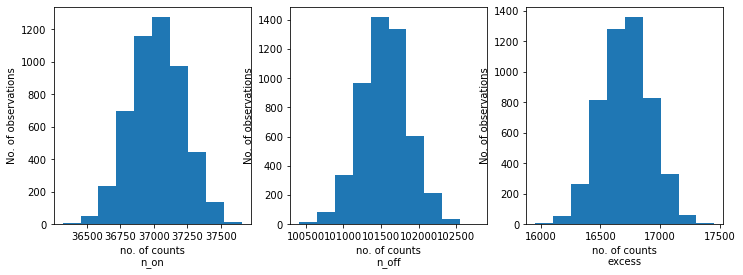

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 14min 45s, sys: 3.26 s, total: 14min 48s
Wall time: 14min 55s


In [15]:
results

[{'index': 2.203480656028608,
  'amplitude': 1.319131223495981e-12,
  'lambda_': 0.013352732699866327},
 {'index': 2.216551178307587,
  'amplitude': 1.2725453446582055e-12,
  'lambda_': 0.012480063961532253},
 {'index': 2.2335639880896676,
  'amplitude': 1.2564924970102983e-12,
  'lambda_': 0.0072483906282169285},
 {'index': 2.2237083872295806,
  'amplitude': 1.2773920002908233e-12,
  'lambda_': 0.010494121103543178},
 {'index': 2.23559148008517,
  'amplitude': 1.2791173736763305e-12,
  'lambda_': 0.007843659678971531},
 {'index': 2.218221845526143,
  'amplitude': 1.2812586132237533e-12,
  'lambda_': 0.009791377910732025},
 {'index': 2.226136664494706,
  'amplitude': 1.2713707997318236e-12,
  'lambda_': 0.005722998180854309},
 {'index': 2.2226220144232536,
  'amplitude': 1.275810972118856e-12,
  'lambda_': 0.008042198413201269},
 {'index': 2.2014059217857174,
  'amplitude': 1.3207168628601819e-12,
  'lambda_': 0.016130245144718953},
 {'index': 2.21359023766153,
  'amplitude': 1.2931702

index: 2.2198831022886765 += 0.009005902502960976


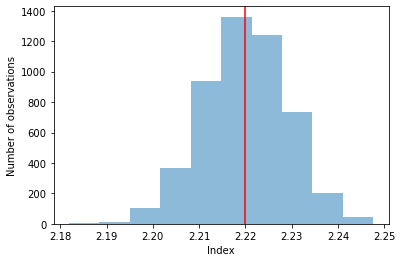

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2895534749388208e-12 += 1.8713709573718668e-14


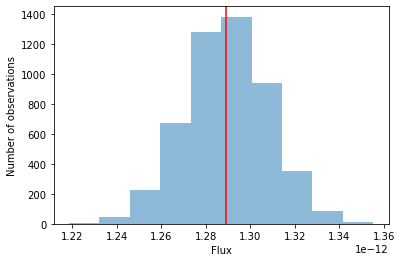

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.01012100182033234 += 0.002725173679885029


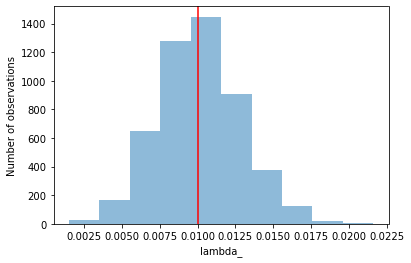

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")